# Hamiltonian NN (HNN) in (q, v) evaluation 
by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
solver = scipy.integrate.solve_ivp

In [ ]:
import torch.nn as nn
device = 'cpu'

In [ ]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
      
    return torch.matmul(gradient[0],St)
   

  def fvec(self,t,x):
    return self.grad(x)

In [4]:
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
mynet = MLP(input_size,hidden_size,output_size).to('cpu')

In [ ]:
M = 100 * 1
tend = 5.0 * 1
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

ture_x shape: (100, 4)


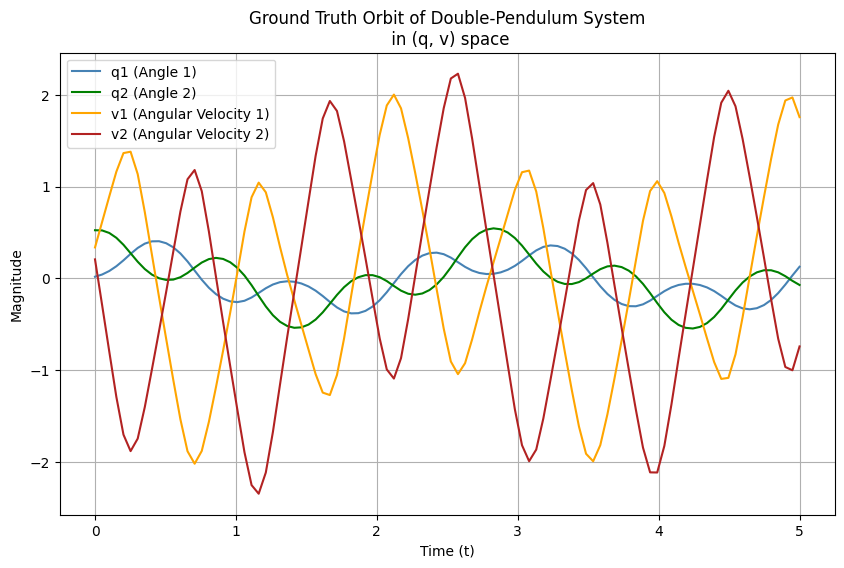

In [ ]:
# Ground truth
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

# equations of motion (q, v space)
def func(t, state):
  """
  ODE of the double-pendulum system (q, v space)
  state = [q1, q2, v1, v2]
  dvdt = [v1, v2, a1, a2]
  """
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  
  # dq/dt = v
  dvdt[0] = state[2] # v1
  dvdt[1] = state[3] # v2
  
  # dv/dt = a (acceleration)
  # a1
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  # a2
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  
  return dvdt

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)

x0 = state[0]

sol = solver(func, [0, tend], x0, t_eval=t_eval)
tval = sol['t']

# ODE in/out v: = (q1, q2, v1, v2) order
q1 = sol['y'][0]
q2 = sol['y'][1]
v1 = sol['y'][2]
v2 = sol['y'][3]
tval = sol['t']

true_x = sol['y'].T

print('ture_x shape:', true_x.shape)

plt.figure(figsize=(10, 6))
plt.plot(tval, q1, 'steelblue', label='q1 (Angle 1)')
plt.plot(tval, q2, 'g', label='q2 (Angle 2)')
plt.plot(tval, v1, 'orange', label='v1 (Angular Velocity 1)')
plt.plot(tval, v2, 'firebrick', label='v2 (Angular Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Ground Truth Orbit of Double-Pendulum System\n in (q, v) space')
plt.legend()
plt.grid(True)
plt.show()



hnn_x shape: (100, 4)


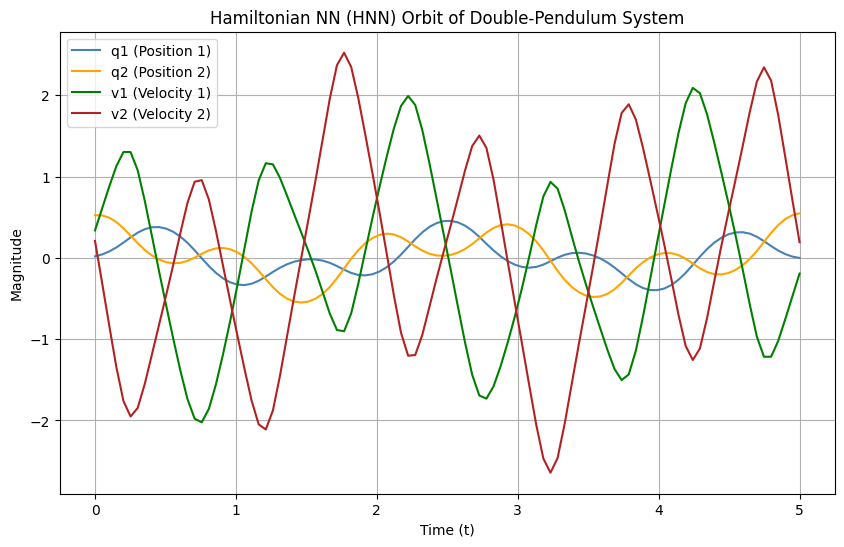

In [ ]:
# simulation
# parameters: same as the ground truth.
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1 + m2

state = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state.append(s)

x0 = state[0]

trial = 9

mynet.load_state_dict(torch.load("./model/danieljh_hnn_dp_sep_sc_2t_lr_{}".format(trial), map_location="cpu"))
mynet.eval()
x0 = state[0]

import pandas as pd
A = pd.read_csv("./data/A_dp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B_dp_sep_sc.csv", header=None, dtype=np.float32)

A = np.asmatrix(A)
B = np.asmatrix(B)
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()
def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,t_eval)

hnn_x = res.copy()

print('hnn_x shape:', hnn_x.shape)

plt.figure(figsize=(10, 6))
plt.plot(t_eval,res[:,0], 'steelblue', label='q1 (Position 1)')
plt.plot(t_eval,res[:,1], 'orange', label='q2 (Position 2)')
plt.plot(t_eval,res[:,2], 'g', label='v1 (Velocity 1)')
plt.plot(t_eval,res[:,3], 'firebrick', label='v2 (Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('Hamiltonian NN (HNN) Orbit of Double-Pendulum System')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def hamiltonian_qv(state):
    """
    Based on the given state vector (q1, q2, v1, v2), 
    computes the total energy (Hamiltonian) of the double-pendulum system.

    Here:
    q1 = theta1 (Angle 1)
    q2 = theta2 (Angle 2)
    v1 = omega1 (Angular Velocity 1)
    v2 = omega2 (Angular Velocity 2)
    """
    theta1 = state[:,0]
    theta2 = state[:,1]
    omega1 = state[:,2]
    omega2 = state[:,3]
    
    # --- Kinetic Energy ---   
    T1 = 0.5 * m1 * (l1 * omega1)**2
    T2 = 0.5 * m2 * (
        (l1 * omega1)**2 + 
        (l2 * omega2)**2 + 
        2 * l1 * l2 * omega1 * omega2 * np.cos(theta1 - theta2)
    )
    kinetic_energy = T1 + T2
    
    # --- Potential Energy ---   
    V1 = -m1 * g * l1 * np.cos(theta1)
    V2 = -m2 * g * (1 * np.cos(theta1) + l2 * np.cos(theta2))
    potential_energy = V1 + V2

    return (kinetic_energy + potential_energy)

Htrue_true_x = hamiltonian_qv(true_x)
Htrue_hnn_x = hamiltonian_qv(hnn_x)

print('Htrue_true_x shape:', Htrue_true_x.shape)
print('Htrue_hnn_x shape:', Htrue_hnn_x.shape)


Htrue_true_x shape: (100,)
Htrue_hnn_x shape: (100,)


In [ ]:
def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

Hmodel_hnn_x = net_energy(hnn_x, t_eval).reshape((M))
Hmodel_true_x = net_energy(true_x, t_eval).reshape((M))


In [ ]:
import os

def save_plot(filename, directory="./eval_figures_per_model", dpi=300):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    filepath = os.path.join(directory, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    
    print(f"Graph saved at: {filepath}")

In [ ]:
def plot_results(true_x, hnn_x, t_eval, Htrue_true_x, Htrue_hnn_x, Hmodel_true_x, Hmodel_hnn_x):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_x[:, 0], 'steelblue', label='q1')
    axes[0, 0].plot(t_eval, true_x[:, 1], 'g', label='q2')
    axes[0, 0].plot(t_eval, true_x[:, 2], 'orange', label='v1')
    axes[0, 0].plot(t_eval, true_x[:, 3], 'firebrick', label='v2')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylim([-3, 3])
    axes[0, 0].set_title("Ground Truth Orbit in (q, v)\n"
                         "(q: Angle, v: Angular Velocity)")
    axes[0, 0].legend(loc='lower right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, hnn_x[:, 0], 'steelblue', label='q1')
    axes[0, 1].plot(t_eval, hnn_x[:, 1], 'g', label='q2')
    axes[0, 1].plot(t_eval, hnn_x[:, 2], 'orange', label='v1')
    axes[0, 1].plot(t_eval, hnn_x[:, 3], 'firebrick', label='v2')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylim([-3,3])
    axes[0, 1].set_title("Hamiltonian NN (HNN) Orbit in (q, v)\n"
                         "(q: Angle, v: Angular Velocity)")
    axes[0, 1].legend(loc='lower right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x, 'k-', label='H_true(True_x)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_hnn_x, 'b--', label='H_true(HNN_x)', linewidth=2)
    axes[1, 0].set_title("True Hamiltonian in (q, v)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('True Energy in (q, v)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    # --- Bottom Right Plot (1, 1): Learned Hamiltonian Perspective ---
    axes[1, 1].plot(t_eval, Hmodel_true_x, 'k-', label='H_hnn (True_x)', linewidth=2)
    axes[1, 1].plot(t_eval, Hmodel_hnn_x, 'r-', label='H_hnn (HNN_x)', linewidth=2)
    axes[1, 1].set_title("Hamiltonian Learned by Hamiltonian NN (HNN) in (q, v)", pad=tpad)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('HNN Energy in (q, v)')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True)

    plt.tight_layout()

    save_plot("hnn_dp_eval_figure_by_danieljh")
 
    plt.show()


Graph saved at: ./eval_figures_per_model/hnn_dp_eval_figure_by_danieljh


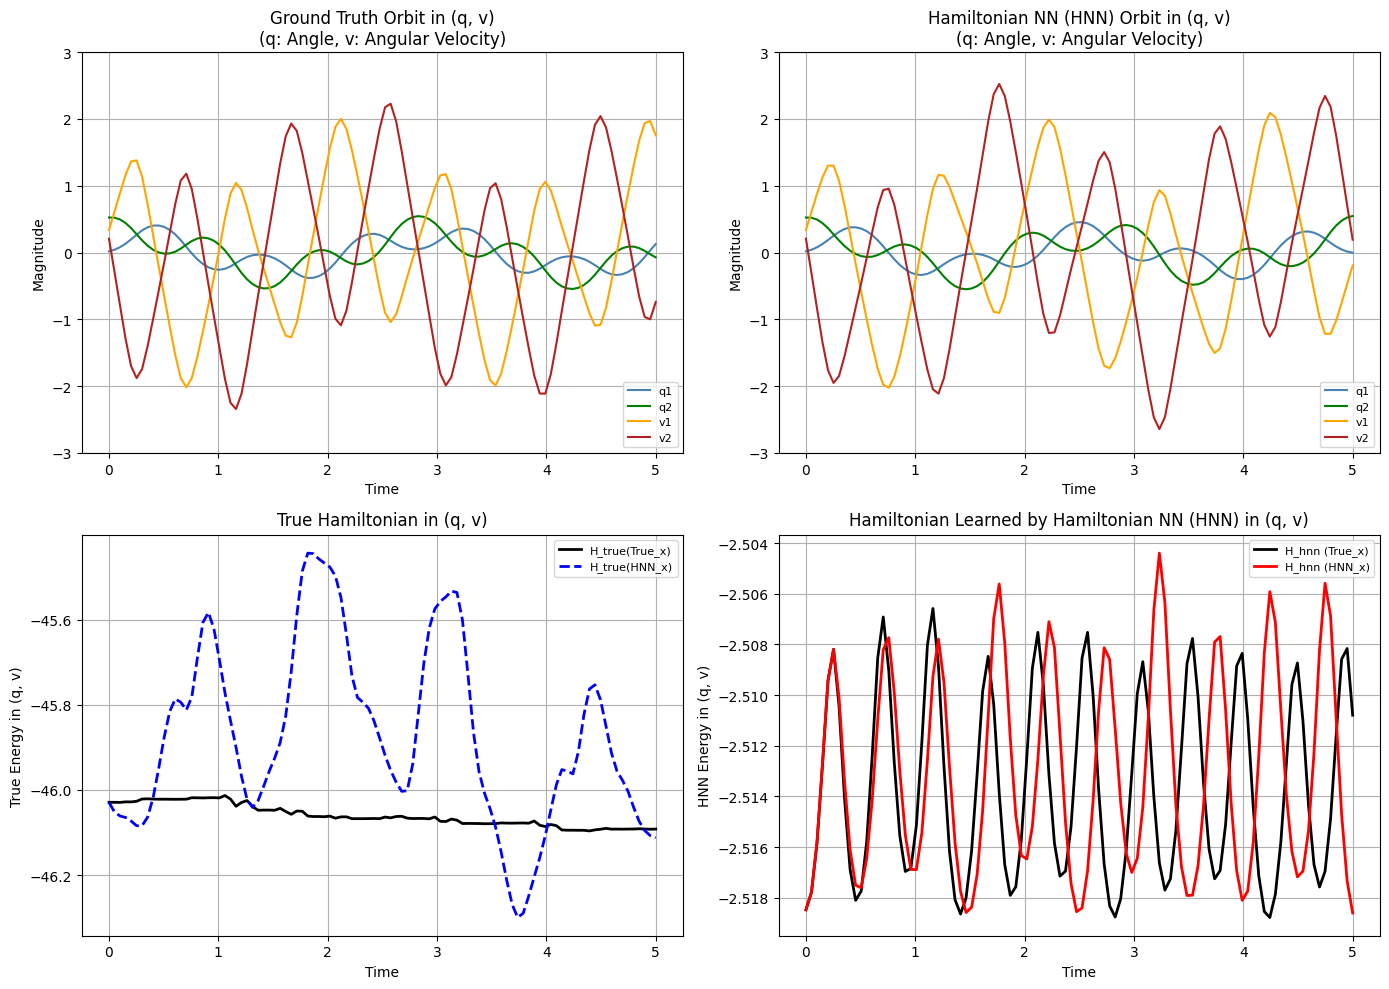

In [12]:
plot_results(true_x, hnn_x, t_eval, Htrue_true_x, Htrue_hnn_x, Hmodel_true_x, Hmodel_hnn_x)

In [ ]:
''' In order to compare performances across models, exports orbit, etc. to file '''
def save_data(data, model="TRUE_dp", item='orbit', t_end=tend, dir = './comparison'): 
    # model = "TRUE", "HNN" "LNN", "SYM", "SKEW", "NODE"
    file_path = dir + f'/{model}_{item}_tend_{t_end}.npy'
    np.save(file_path, data)

    print(f"Data have successfully saved to {file_path}.")

In [ ]:
save_data(true_x)
save_data(res, model="HNN_dp")
save_data(Htrue_true_x, model="TRUE_dp", item="Htrue_true_x")
save_data(Htrue_hnn_x, model="TRUE_dp", item='Htrue_hnn_x')
save_data(Hmodel_true_x, model="HNN_dp", item='Hmodel_true_x')
save_data(Hmodel_hnn_x, model="HNN_dp", item='Hmodel_hnn_x')

데이터가 ./comparison/TRUE_dp_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/TRUE_dp_Htrue_true_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/TRUE_dp_Htrue_hnn_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_Hmodel_true_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/HNN_dp_Hmodel_hnn_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
